In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import re
import string
!pip install nltk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
import time

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def get_data(nome_arquivo,shuffle):
    ds = pd.read_csv(nome_arquivo,encoding="utf-8")
    if shuffle:
        ds = ds.sample(frac=1)
    ds['texto'] = ds['texto'].apply(str)
    return ds

In [ ]:
stop = set(stopwords.words("portuguese"))

def remove_stopwords(text):
    filtered_words = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(filtered_words)

def remove_URL(text):
    url = re.compile(r"https?://\S+|www\.\S+")
    return url.sub(r"",text)

def remove_punct(text):
    translator = str.maketrans("","",'!""#$%&\'()*+,./:;<=>?@[\\]^_`{|}~º')
    translator = str.maketrans("","",'!""#$%&\'()*+,./:;<=>?@[\\]^_`{|}~º')
    return text.translate(translator)

def remove_numbers(text):
    result = ''.join([i for i in text if not i.isdigit()])
    return result

def remove_hifen(text):
    translator = str.maketrans('-',' ')
    return text.translate(translator)

In [ ]:
pattern = re.compile(r"https?//(\S+|www)\.\S+")
def pat(df_t):
    for t in df_t.texto:
        matches = pattern.findall(t)
        for match in  matches:
            print(t)
            print(match)
            print(pattern.sub(r"",t))        
        if len(matches)> 0:
            break

In [ ]:
def make_test(df_t):
    df_t["texto"] = df_t.texto.map(remove_URL)
    #df_t["texto"] = df_t.texto.map(remove_punct)
    df_t["texto"] = df_t.texto.map(remove_hifen)
    #df_t["texto"] = df_t.texto.map(remove_numbers)
    df_t["texto"] = df_t.texto.map(remove_stopwords)

In [ ]:
def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count

In [ ]:
def data_split(df,size):
    train_size = int(df.shape[0]*size)
    train_df = df[:train_size]
    val_df = df[train_size:]
    return train_df, val_df

In [ ]:
def precision(test_labels,predictions):
    counter = len(test_labels)
    list_c = [i for i,j in zip(predictions,test_labels) if i == j]
    return len(list_c)/counter*100

In [ ]:
def prepare(teste):
    teste = remove_URL(teste)
    #teste = remove_punct(teste)
    teste = remove_hifen(teste)
    teste = remove_stopwords(teste)    
    return teste

In [ ]:
df = get_data('train.csv',1)

In [ ]:
df.shape

(820, 2)

In [ ]:
df.head()

,valor,texto
15,1,Pinças ópticas têm sido utilizadas para o apri...
16,1,O trabalho aborda estudos iniciais para elabor...
126,1,Este trabalho propõe a avaliação de desempenho...
419,0,"Atualmente, o estudo da viabilidade da instala..."
665,0,O presente trabalho teve por objetivo estudar ...


In [ ]:
len(df)

820

In [ ]:
pat(df)
make_test(df)

<Figure size 1152x720 with 0 Axes>

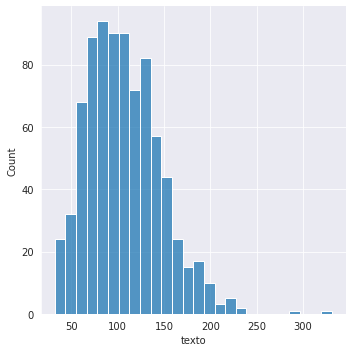

In [ ]:
import seaborn as sns
seqlen = df['texto'].apply(lambda x: len(x.split()))
sns.set_style('darkgrid')
plt.figure(figsize=(16,10))
sns.displot(seqlen)

In [ ]:
SEQ_LEN = 200

In [ ]:
!pip install transformers
from transformers import AutoTokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')

In [ ]:
tokens = tokenizer.encode_plus("Este trabalho aborda sistemas de energia", max_length=10, truncation= True, padding="max_length", 
                               add_special_tokens= True, return_token_type_ids= False, return_attention_mask= True, return_tensors= 'tf')

In [ ]:
Xids = np.zeros((len(df),SEQ_LEN))
Xmask = np.zeros((len(df),SEQ_LEN))

In [ ]:
Xids.shape

(820, 200)

In [ ]:
for i, sequence in enumerate(df['texto']):
    tokens = tokenizer.encode_plus(sequence, max_length=SEQ_LEN, truncation= True, padding="max_length", 
                               add_special_tokens= True, return_token_type_ids= False, return_attention_mask= True, return_tensors= 'tf')
    Xids[i,:], Xmask[i,:] = tokens['input_ids'], tokens['attention_mask']

In [ ]:
Xids

array([[  101., 13718.,   759., ...,  8788.,   266.,   102.],
       [  101.,  1223.,  5516., ...,     0.,     0.,     0.],
       [  101.,  1223., 14290., ..., 21520.,   300.,   102.],
       ...,
       [  101.,  1223.,  4159., ...,     0.,     0.,     0.],
       [  101.,  3232.,   481., ...,  2401.,  8823.,   102.],
       [  101.,  2499.,  7203., ...,     0.,     0.,     0.]])

In [ ]:
Xmask

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 0., 0., 0.]])

In [ ]:
df['valor'].unique

<bound method Series.unique of 15     1
16     1
126    1
419    0
665    0
      ..
225    1
522    0
204    1
68     1
616    0
Name: valor, Length: 820, dtype: int64>

In [ ]:
arr = df['valor'].values
arr.size

820

In [ ]:
labels = np.zeros((arr.size, arr.max()+1))
labels.shape

(820, 2)

In [ ]:
labels[np.arange(arr.size),arr] = 1
labels

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]])

In [ ]:
with open('xids.npy','wb') as f:
  np.save(f,Xids)
with open('xmask.npy','wb') as f:
  np.save(f,Xmask)
with open('labels.npy','wb') as f:
  np.save(f,labels)

In [ ]:
del Xids, Xmask, labels

In [ ]:
with open('xids.npy','rb') as fp:
  Xids = np.load(fp)
with open('xmask.npy','rb') as fp:
  Xmask = np.load(fp)
with open('labels.npy','rb') as fp:
  labels = np.load(fp)

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((Xids,Xmask,labels))

In [ ]:
#for i in dataset.take(1):
  #print(i)

In [ ]:
def map_function(input_ids,mask,labels):
  return {'input_ids':input_ids, 'attention_mask':mask}, labels

In [ ]:
def remap_function(input_ids,mask):
  return {'input_ids':input_ids,'attention_mask':mask}

In [ ]:
dataset = dataset.map(map_function)

In [ ]:
for i in dataset.take(1):
  print(i)

({'input_ids': <tf.Tensor: shape=(200,), dtype=float64, numpy=
array([  101., 13718.,   759., 20814., 22281.,  1854.,   908.,  7671.,
       14067.,  1845., 18466.,  8536.,  5768.,  7247., 11649., 22281.,
         229.,   300.,  7247., 11649., 22281.,  9291.,  7742.,  2070.,
        2276., 16177.,   117.,  7930.,   117.,  4810.,  7504.,   119.,
        2086.,  3385.,  2996., 14523., 20638.,  3093.,   852.,   442.,
        1854.,   908., 20473.,  2630.,  4457., 13281.,  3077., 18466.,
         117.,  3674.,  2996., 14523.,   760., 15173.,  2996.,  2650.,
        5294., 22281., 10372.,  1229.,  6626.,  1589.,  5678.,   117.,
        5966.,  2143., 11577., 19330.,   933.,   119.,  5180.,  3308.,
        2811.,  6797.,  4719.,  5584., 19291., 22281.,   498.,  8040.,
        7504.,  6854., 10779.,   117.,  2630.,  2811.,  1223.,  7218.,
        1756., 11573., 10712.,  2376., 20814., 22281.,  4130., 20814.,
       12894.,  8255., 10367.,  2996., 14523., 16611.,  2860., 10116.,
        2244.,

In [ ]:
dataset = dataset.shuffle(10000).batch(2)

In [ ]:
DS_LEN = len(list(dataset))
DS_LEN

410

In [ ]:
split = .9
train = dataset.take(round(DS_LEN*split))
val = dataset.skip(round(DS_LEN*split))

In [ ]:
from transformers import TFAutoModel
bert = TFAutoModel.from_pretrained('neuralmind/bert-base-portuguese-cased', from_pt= True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

In [ ]:
input_ids = tf.keras.layers.Input(shape=(SEQ_LEN,),name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(SEQ_LEN,),name='attention_mask', dtype='int32')

embeddings = bert(input_ids, attention_mask = mask)[0]

X = tf.keras.layers.GlobalMaxPool1D()(embeddings)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Dense(64, activation='relu')(X)
X = tf.keras.layers.Dropout(0.1)(X)
X = tf.keras.layers.Dense(32, activation='relu')(X)
Y = tf.keras.layers.Dense(2, activation='softmax', name='outputs')(X)

model = tf.keras.Model(inputs=[input_ids,mask],outputs=Y)

In [ ]:
model.layers[2].trainable = False

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 200)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 200)]        0                                            
__________________________________________________________________________________________________
tf_bert_model_5 (TFBertModel)   TFBaseModelOutputWit 108923136   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
global_max_pooling1d_2 (GlobalM (None, 768)          0           tf_bert_model_5[0][0]      

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.001,decay=1e-6)
loss = tf.keras.losses.CategoricalCrossentropy()  # categorical = one-hot
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

import time
start = time.perf_counter()

history = model.fit(train, validation_data=val, epochs=50, verbose = 2)

finish = time.perf_counter()
print(f'\nFinished in {round(finish-start, 2)} second(s)')

Epoch 1/50
369/369 - 62s - loss: 0.7286 - accuracy: 0.5921 - val_loss: 0.4687 - val_accuracy: 0.7317
Epoch 2/50
369/369 - 40s - loss: 0.6418 - accuracy: 0.6585 - val_loss: 0.4790 - val_accuracy: 0.7439
Epoch 3/50
369/369 - 40s - loss: 0.6248 - accuracy: 0.6762 - val_loss: 0.5749 - val_accuracy: 0.7195
Epoch 4/50
369/369 - 40s - loss: 0.6388 - accuracy: 0.6545 - val_loss: 0.5194 - val_accuracy: 0.7927
Epoch 5/50
369/369 - 40s - loss: 0.6005 - accuracy: 0.6938 - val_loss: 0.3651 - val_accuracy: 0.8659
Epoch 6/50
369/369 - 40s - loss: 0.6071 - accuracy: 0.6734 - val_loss: 0.4992 - val_accuracy: 0.7927
Epoch 7/50
369/369 - 40s - loss: 0.5801 - accuracy: 0.6870 - val_loss: 0.3515 - val_accuracy: 0.8902
Epoch 8/50
369/369 - 40s - loss: 0.5720 - accuracy: 0.7087 - val_loss: 0.2183 - val_accuracy: 0.9390
Epoch 9/50
369/369 - 40s - loss: 0.5475 - accuracy: 0.7209 - val_loss: 0.3585 - val_accuracy: 0.8049
Epoch 10/50
369/369 - 40s - loss: 0.5670 - accuracy: 0.6992 - val_loss: 0.3114 - val_accura

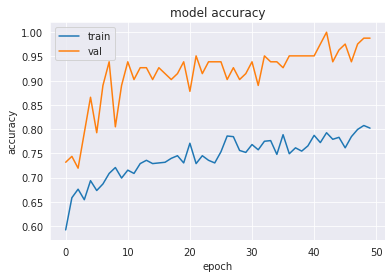

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.savefig('model_accuracy.png')

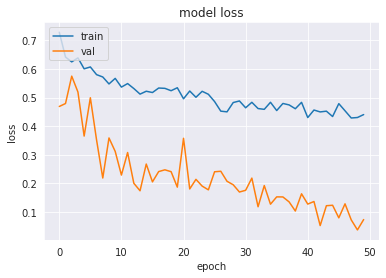

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.savefig('model_loss.png')

In [ ]:
dt = get_data('eval.csv',1)

pat(dt)
make_test(dt)

test_sentences = dt.texto.to_numpy()
test_labels = dt.valor.to_numpy()

In [ ]:
Tids = np.zeros((len(dt),SEQ_LEN))
Tmask = np.zeros((len(dt),SEQ_LEN))

In [ ]:
for i, sequence in enumerate(dt['texto']):
    tokensT = tokenizer.encode_plus(sequence, max_length=SEQ_LEN, truncation= True, padding="max_length", 
                               add_special_tokens= True, return_token_type_ids= False, return_attention_mask= True, return_tensors= 'tf')
    Tids[i,:], Tmask[i,:] = tokensT['input_ids'], tokensT['attention_mask']

In [ ]:
Tids

array([[  101.,  1223.,  4593., ...,     0.,     0.,     0.],
       [  101.,  4611.,  5890., ...,     0.,     0.,     0.],
       [  101.,  2630., 10537., ...,   154.,   113.,   102.],
       ...,
       [  101.,  3102.,  1223., ..., 13874.,  4574.,   102.],
       [  101.,  1223.,  2064., ...,     0.,     0.,     0.],
       [  101., 14296.,   117., ...,     0.,     0.,     0.]])

In [ ]:
Tmask

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]])

In [ ]:
arrT = dt['valor'].values
labelsT = np.zeros((arrT.size, arrT.max()+1))
labelsT[np.arange(arrT.size),arrT] = 1

In [ ]:
datasetT = tf.data.Dataset.from_tensor_slices((Tids,Tmask,labelsT))

In [ ]:
labelsT

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [ ]:
datasetT = datasetT.map(map_function)

In [ ]:
datasetT = datasetT.batch(2)

In [ ]:
predictions_t = model.predict(datasetT)
predictions_t = [np.argmax(element) for element in predictions_t]
print(predictions_t)
print(precision(test_labels,predictions_t))

[0, 1, 1, 1, 1, 0, 0, 0]
100.0


In [ ]:
datasetTT = tf.data.Dataset.from_tensor_slices((Tids,Tmask))
datasetTT = datasetTT.map(remap_function)
datasetTT = datasetTT.batch(2)


In [ ]:
predictions_t = model.predict(datasetTT)
predictions_t = [np.argmax(element) for element in predictions_t]
print(predictions_t)
print(precision(test_labels,predictions_t))

[0, 1, 1, 1, 1, 0, 0, 0]
100.0


In [ ]:
val

<SkipDataset shapes: ({input_ids: (None, 200), attention_mask: (None, 200)}, (None, 2)), types: ({input_ids: tf.float64, attention_mask: tf.float64}, tf.float64)>

In [ ]:
datasetT

<BatchDataset shapes: ({input_ids: (None, 200), attention_mask: (None, 200)}, (None, 2)), types: ({input_ids: tf.float64, attention_mask: tf.float64}, tf.float64)>

In [ ]:
"""
model.save('./saved_models')
model.save_spec('./saved_models')
model.save_weights('./saved_models')
bert.save_pretrained('./saved_BertModel')
bert.save_weights('./saved_BertModel')
tokenizer.save_pretrained('./saved_tokenizer')
"""


"\nmodel.save('./saved_models')\nmodel.save_spec('./saved_models')\nmodel.save_weights('./saved_models')\nbert.save_pretrained('./saved_BertModel')\nbert.save_weights('./saved_BertModel')\ntokenizer.save_pretrained('./saved_tokenizer')\n"

In [ ]:
"""
from transformers import BertTokenizer
new_modelo = TFAutoModel.from_pretrained('./saved_BertModel/')
#new_model = tf.keras.models.load_model('./saved_models')
tokenizer2 = BertTokenizer.from_pretrained('./saved_tokenizer/')
"""


"\nfrom transformers import BertTokenizer\nnew_modelo = TFAutoModel.from_pretrained('./saved_BertModel/')\n#new_model = tf.keras.models.load_model('./saved_models')\ntokenizer2 = BertTokenizer.from_pretrained('./saved_tokenizer/')\n"

In [ ]:
tokens = tokenizer.encode_plus("Este trabalho aborda sistemas de energia", max_length=10, truncation= True, padding="max_length", 
                               add_special_tokens= True, return_token_type_ids= False, return_attention_mask= True, return_tensors= 'tf')
tokens

{'input_ids': <tf.Tensor: shape=(1, 10), dtype=int32, numpy=
array([[ 101, 1681, 1223, 5516, 3184,  125, 2608,  102,    0,    0]],
      dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 10), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0]], dtype=int32)>}

In [ ]:
teste_1 = "O objetivo deste trabalho é propor um algoritmo para realizar a identificação de padrões na vocalização suína, visando determinar o nível do bem-estar do animal. Tal análise foi proposta uma vez que o bem-estar animal é um assunto cada vez mais abordado no mundo todo, principalmente quando os animais são criados para o abate. Dessa forma, a criação de um método em que haja o mínimo de contato com os animais se faz importante, evitando que tal contato altere o comportamento do animal e, conseqüentemente, o resultado da análise de seu bem-estar. Por essas características, foi proposto um método de análise dos sons emitidos pelos suínos com base na utilização de uma Rede Neural Artificial do tipo Radial Basis Function, a qual possui como elementos de treinamento e operação um conjunto de características extraídas através da Transformada Discreta Wavelet de sinais sonoros pré-gravados. As características obtidas dos sinais foram as energias das bandas críticas relativas à Escala Bark e a diferença entre as energias das bandas adjacentes, além dimensão fractal do sinal. Através desse método foram analisados dois tipos de sinais sonoros: a vocalização de leitões saudáveis e de leitões acometidos por uma doença chamada Artrite Traumática; e a vocalização de suínos adultos em situações de conforto e desconforto. Os resultados demonstram que a análise proposta atingiu bons patamares de acerto na determinação do bem-estar do animal"
#eletronica1

In [ ]:
teste_1 = prepare(teste_1)

In [ ]:
def previsao(teste,modelT):
  teste = prepare(teste)
  tokensT = tokenizer.encode_plus(teste, max_length=SEQ_LEN, truncation= True, padding="max_length", 
                               add_special_tokens= True, return_token_type_ids= False, return_attention_mask= True, return_tensors= 'tf')
  TTID, TTM = tokensT['input_ids'], tokensT['attention_mask']
  TT_seq = tf.data.Dataset.from_tensor_slices((TTID,TTM))
  TT_seq = TT_seq.map(remap_function)
  TT_seq = TT_seq.batch(2)  
  predictionsT= modelT.predict(TT_seq)
  #print(predictionsT)
  result = np.argmax(predictionsT)
  return result


In [ ]:
tokensT = tokenizer.encode_plus(teste_1, max_length=SEQ_LEN, truncation= True, padding="max_length", 
                               add_special_tokens= True, return_token_type_ids= False, return_attention_mask= True, return_tensors= 'tf')

T1ID, T1M = tokensT['input_ids'], tokensT['attention_mask']

In [ ]:
teste_1_seq = tf.data.Dataset.from_tensor_slices((T1ID,T1M))
teste_1_seq = teste_1_seq.map(remap_function)
teste_1_seq = teste_1_seq.batch(2)

In [ ]:
predictions= model.predict(teste_1_seq)
print(predictions)
print(np.argmax(predictions))

[[0.00175535 0.99824464]]
1


In [ ]:
previsao(teste_1,model)

1

In [ ]:
teste_2 = "Produzindo inicialmente motores elétricos, a WEG ampliou suas atividades a partir da década de 80, com a produção de componentes eletroeletrônicos, produtos para automação industrial, transformadores de força e distribuição, tintas líquidas e em pó e vernizes eletroisolantes. A empresa se consolidou não só como fabricante de motores, mas como fornecedora de sistemas elétricos industriais completos."
#eletrica0

In [ ]:
previsao(teste_2,model)

0

In [ ]:
teste_3 = "Numa definição mais abrangente, podemos dizer que a eletrônica é o ramo da ciência que estuda o uso de circuitos formados por componentes elétricos e eletrônicos, com o objetivo principal de representar, armazenar, transmitir ou processar informações além do controle de processos e servomecanismos. Sob esta ótica, também se pode afirmar que os circuitos internos dos computadores (que armazenam e processam informações), os sistemas de telecomunicações (que transmitem informações), os diversos tipos de sensores e transdutores (que representam grandezas físicas - informações - sob forma de sinais elétricos) estão, todos, dentro da área de interesse da eletrônica."
#eletronica1

In [ ]:
previsao(teste_3,model)

1

In [ ]:
teste_4 = "projeto visa nova abordagem sistema vigilância móvel autônomo. pulseira biométrica coleta dados sobre batimento cardíaco usuário envia, via bluetooth, módulo processamento, smartphone sistema operacional android, faz análise destes batimentos cardíacos define usuário passando alguma situação risco morte, extremo estresse. smartphone escreve, periodicamente, informações tempo imediato sobre usuário, localização geográfica batimentos cardíacos, banco dados nuvem que, vez, contém informações pessoais usuário, tipo sanguíneo, telefone contato emergencial, alergias, outros. premissa dados nuvem acessíveis todo momento servidor externo servirem base socorro médico emergencial, seja, sistema visa prover auxílio imediato maneira proativa autônoma, modo preservar vidas, sendo baixo custo alcançável grande parte população. realizados diversos testes simulações demonstrando adequabilidade sistema proposto situações problema apresentadas"
#eletronica

In [ ]:
previsao(teste_4,model)

1

In [ ]:
"""
@inproceedings{souza2020bertimbau,
    author    = {Souza, F{\'a}bio and Nogueira, Rodrigo and Lotufo, Roberto},
    title     = {{BERT}imbau: pretrained {BERT} models for {B}razilian {P}ortuguese},
    booktitle = {9th Brazilian Conference on Intelligent Systems, {BRACIS}, Rio Grande do Sul, Brazil, October 20-23 (to appear)},
    year      = {2020}
}

@article{souza2019portuguese,
    title={Portuguese Named Entity Recognition using BERT-CRF},
    author={Souza, F{\'a}bio and Nogueira, Rodrigo and Lotufo, Roberto},
    journal={arXiv preprint arXiv:1909.10649},
    url={http://arxiv.org/abs/1909.10649},
    year={2019}
}
"""

"\n@inproceedings{souza2020bertimbau,\n    author    = {Souza, F{'a}bio and Nogueira, Rodrigo and Lotufo, Roberto},\n    title     = {{BERT}imbau: pretrained {BERT} models for {B}razilian {P}ortuguese},\n    booktitle = {9th Brazilian Conference on Intelligent Systems, {BRACIS}, Rio Grande do Sul, Brazil, October 20-23 (to appear)},\n    year      = {2020}\n}\n\n@article{souza2019portuguese,\n    title={Portuguese Named Entity Recognition using BERT-CRF},\n    author={Souza, F{'a}bio and Nogueira, Rodrigo and Lotufo, Roberto},\n    journal={arXiv preprint arXiv:1909.10649},\n    url={http://arxiv.org/abs/1909.10649},\n    year={2019}\n}\n"